In [1]:
import xspec
import batanalysis as ba
from swifttools.swift_too import GUANO, ObsQuery, Clock
import swiftbat

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from pathlib import Path
from astropy.io import fits
from astropy.time import Time, TimeDelta
import astropy.units as u
from astropy.coordinates import SkyCoord
import datetime
import os

In [2]:
tmp_download_dir="/tmp/batdata/download_examples"

ba.datadir(tmp_download_dir, mkdir=True)


PosixPath('/private/tmp/batdata/download_examples')

In [3]:
query = ObsQuery(targetid=147478)
query

2005-07-24 12:34:18,2005-07-24 13:13:12,GRB050724,00147478000,2270,64
2005-07-24 14:04:29,2005-07-24 14:49:29,GRB050724,00147478000,2561,139
2005-07-24 15:40:54,2005-07-24 16:25:54,GRB050724,00147478000,2561,139
2005-07-24 17:17:19,2005-07-24 18:02:19,GRB050724,00147478000,2572,128
2005-07-24 18:53:45,2005-07-24 19:38:45,GRB050724,00147478000,2573,127
2005-07-24 20:31:03,2005-07-24 21:15:20,GRB050724,00147478000,2530,127
2005-07-24 22:06:36,2005-07-24 22:51:36,GRB050724,00147478000,2583,117
2005-07-24 23:43:02,2005-07-25 00:28:02,GRB050724,00147478000,2583,117
2005-07-25 01:19:27,2005-07-25 02:04:27,GRB050724,00147478000,2636,64
2005-07-25 02:55:53,2005-07-25 03:40:53,GRB050724,00147478000,2636,64
2005-07-25 04:32:19,2005-07-25 05:17:19,GRB050724,00147478000,2636,64


In [3]:
query = ObsQuery(name="GRB050724")
query

2005-07-24 12:34:18,2005-07-24 13:13:12,GRB050724,00147478000,2270,64
2005-07-24 14:04:29,2005-07-24 14:49:29,GRB050724,00147478000,2561,139
2005-07-24 15:40:54,2005-07-24 16:25:54,GRB050724,00147478000,2561,139
2005-07-24 17:17:19,2005-07-24 18:02:19,GRB050724,00147478000,2572,128
2005-07-24 18:53:45,2005-07-24 19:38:45,GRB050724,00147478000,2573,127
2005-07-24 20:31:03,2005-07-24 21:15:20,GRB050724,00147478000,2530,127
2005-07-24 22:06:36,2005-07-24 22:51:36,GRB050724,00147478000,2583,117
2005-07-24 23:43:02,2005-07-25 00:28:02,GRB050724,00147478000,2583,117
2005-07-25 01:19:27,2005-07-25 02:04:27,GRB050724,00147478000,2636,64
2005-07-25 02:55:53,2005-07-25 03:40:53,GRB050724,00147478000,2636,64
2005-07-25 04:32:19,2005-07-25 05:17:19,GRB050724,00147478000,2636,64


In [4]:
download = ba.download_swiftdata(observations=query[0].obsid)
print(download)

{'00147478000': {'obsid': '00147478000', 'success': True, 'obsoutdir': PosixPath('/private/tmp/batdata/download_examples/00147478000'), 'quicklook': False, 'data': Swift_Data(username='anonymous',obsid='00147478000',quicklook='False',auxil='True',bat='True',xrt='False',uvot='False',log='False',tdrss='True')}}


In [5]:
event=ba.BatEvent(query[0].obsid)

A save file has been written to /private/tmp/batdata/download_examples/00147478000_eventresult/batevent.pickle.


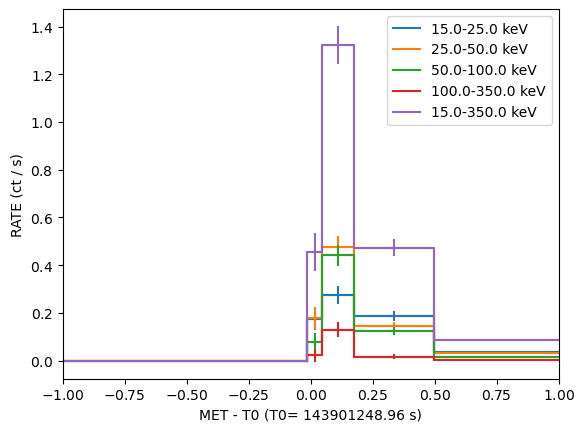

In [21]:
lc=event.create_lightcurve()
fig, ax =lc.plot(T0=event.trigtime.met, plot_relative=True)
ax.set_xlim([-1, 1])


In [8]:
lc.set_timebins(timebinalg="bayesian", save_durations=True)

In [13]:
print(f"The measured T90 is {lc.tdurs['T90']['TSTOP']-lc.tdurs['T90']['TSTART']}\nmeasured from {lc.tdurs['T90']['TSTART']-event.trigtime.met*u.s}-{lc.tdurs['T90']['TSTOP']-event.trigtime.met*u.s}" )
print(f"The measured {lc.tdurs['PEAK']['TSTOP']-lc.tdurs['PEAK']['TSTART']} peak is \nmeasured from {lc.tdurs['PEAK']['TSTART']-event.trigtime.met*u.s}-{lc.tdurs['PEAK']['TSTOP']-event.trigtime.met*u.s}" )
print(f"The measured T100 is {lc.tdurs['TOT']['TSTOP']-lc.tdurs['TOT']['TSTART']}\nmeasured from {lc.tdurs['TOT']['TSTART']-event.trigtime.met*u.s}-{lc.tdurs['TOT']['TSTOP']-event.trigtime.met*u.s}" )

The measured T90 is 99.26400002837181 s
measured from 0.04799997806549072 s-99.3120000064373 s
The measured 1.0 s peak is 
measured from -0.06799998879432678 s-0.9320000112056732 s
The measured T100 is 107.19999998807907 s
measured from -0.01600000262260437 s-107.18399998545647 s


{'T90': {'TSTART': <Quantity 1.43901249e+08 s>, 'TSTOP': <Quantity 1.43901348e+08 s>}, 'T50': {'TSTART': <Quantity 1.43901251e+08 s>, 'TSTOP': <Quantity 1.43901326e+08 s>}, 'PEAK': {'TSTART': <Quantity 1.43901249e+08 s>, 'TSTOP': <Quantity 1.4390125e+08 s>}, 'TOT': {'TSTART': <Quantity 1.43901249e+08 s>, 'TSTOP': <Quantity 1.43901356e+08 s>}, 'BKG1': {'TSTART': <Quantity -1.e+307 s>, 'TSTOP': <Quantity 1.43901249e+08 s>}, 'BKG2': {'TSTART': <Quantity 1.43901356e+08 s>, 'TSTOP': <Quantity 1.e+307 s>}}
{'TIME_CENT': <Quantity [1.43901099e+08, 1.43901249e+08, 1.43901249e+08, 1.43901249e+08,
           1.43901251e+08, 1.43901304e+08, 1.43901454e+08] s>, 'TIME_START': <Quantity [1.43900950e+08, 1.43901249e+08, 1.43901249e+08, 1.43901249e+08,
           1.43901249e+08, 1.43901252e+08, 1.43901356e+08] s>, 'TIME_STOP': <Quantity [1.43901249e+08, 1.43901249e+08, 1.43901249e+08, 1.43901249e+08,
           1.43901252e+08, 1.43901356e+08, 1.43901552e+08] s>}


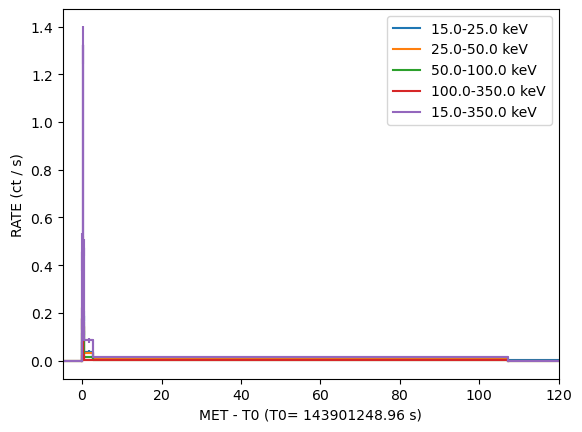

In [11]:
fig, ax = lc.plot(T0=event.trigtime.met, plot_relative=True)
ax.set_xlim([-5, +120])
print(lc.tdurs)
print(lc.tbins)

In [12]:
spectrum_t90=event.create_pha(tstart=lc.tdurs['T90']['TSTART'], tstop=lc.tdurs['T90']['TSTOP'])


1 spectrum  in use
 
Spectral Data File: t_143901249.008-143901348.272_80chan.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.080e-02 +/- 2.110e-03
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-80
  Telescope: SWIFT Instrument: BAT  Channel Type: PI
  Exposure Time: 99.26 sec
 Using fit statistic: chi
 Using Response (RMF) File            t_143901249.008-143901348.272_80chan.rsp for Source 1


Model cflux<1>*powerlaw<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   cflux      Emin       keV      0.500000     frozen
   2    1   cflux      Emax       keV      10.0000      frozen
   3    1   cflux      lg10Flux   cgs      -12.0000     +/-  0.0          
   4    2   powerlaw   PhoIndex            1.00000      +/-  0.0          
   5    2   powerlaw   norm                1.00000      +/-  0.0          
________________________________________________________________________


Fit statistic  : Chi-Squared      

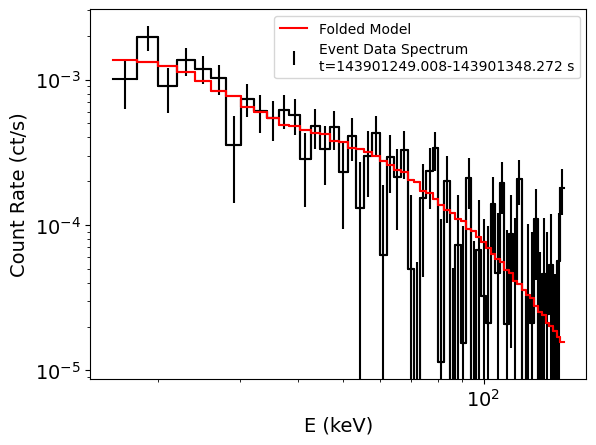

In [14]:
ba.fit_spectrum(spectrum_t90)

In [15]:
spectrum_t90.spectral_model

{'parameters': {'Emin': {'val': 15.0,
   'lolim': 0.0,
   'hilim': 0.0,
   'errflag': 'FFFFFTFFF'},
  'Emax': {'val': 150.0, 'lolim': 0.0, 'hilim': 0.0, 'errflag': 'FFFFFTFFF'},
  'lg10Flux': {'val': -8.007266196967619,
   'lolim': -8.7285754501563,
   'hilim': -7.429853863388389,
   'errflag': 'FFFFFFFFF'},
  'PhoIndex': {'val': 1.750545606362729,
   'lolim': -0.5382617991590737,
   'hilim': 4.317071040790413,
   'errflag': 'FFFFFFFFF'},
  'norm': {'val': 0.001, 'lolim': 0.0, 'hilim': 0.0, 'errflag': 'FFFFFTFFF'}},
 'data': {'model_spectrum': <Quantity [1.36575612e-03, 1.31072299e-03, 1.23782004e-03, 1.12947699e-03,
             9.83720493e-04, 8.35807404e-04, 7.74337648e-04, 6.51264082e-04,
             6.01292612e-04, 5.45516015e-04, 4.85896857e-04, 4.78742573e-04,
             4.48010438e-04, 4.25913225e-04, 4.21536802e-04, 3.77822018e-04,
             3.74201082e-04, 3.36773921e-04, 3.34533071e-04, 3.15532834e-04,
             2.97052404e-04, 2.75852168e-04, 2.57063895e-04, 2.3858

In [16]:
bayesian_spectra=event.create_pha(tstart=lc.tbins["TIME_START"], tstop=lc.tbins["TIME_STOP"])

In [17]:
output_bayesian_spectra=ba.parallel.batspectrum_analysis(bayesian_spectra, generic_model="cflux*po", setPars={1:"15,-1", 2:"150,-1",3:-9, 4:"-1",5:".001,-1"}, nprocs=1, use_cstat=False, fit_iterations=10000, recalc=True)


1 spectrum  in use
 
Spectral Data File: t_143900950.0-143901248.944_80chan.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  -8.224e-04 +/- 1.204e-03
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-80
  Telescope: SWIFT Instrument: BAT  Channel Type: PI
  Exposure Time: 298.9 sec
 Using fit statistic: cstat
 Using Response (RMF) File            t_143900950.0-143901248.944_80chan.rsp for Source 1


Fit statistic  : C-Statistic                    8.51     using 80 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                  527.95     using 80 bins.
 Null hypothesis probability of 5.31e-68 with 78 degrees of freedom
 Current data and model not fit yet.

Model cflux<1>*powerlaw<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   cflux      Emin       keV      0.500000     frozen
   2    1   cflux      Emax       keV      10.0000      frozen
   3    1   cflux      lg10Flux   cg


1 spectrum  in use
 
Spectral Data File: t_143901248.944-143901249.00800002_80chan_bkgnsigma_5_upperlim.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.993e+00 +/- 1.866e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-80
  Telescope: SWIFT Instrument: BAT  Channel Type: PI
  Exposure Time: 0.064 sec
 Using fit statistic: chi
 Using Response (RMF) File            t_143901248.944-143901249.00800002_80chan.rsp for Source 1


Fit statistic  : Chi-Squared                29056.76     using 80 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number: 1

Test statistic : Chi-Squared                29056.76     using 80 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number(s): 1 

 Null hypothesis probability of 0.00e+00 with 78 degrees of freedom
 Current data and model not fit yet.

Model powerlaw<1> Source No.: 1   Active/On
Model Model Component  Paramet


Fit statistic  : Chi-Squared                  440.69     using 80 bins.

Test statistic : Chi-Squared                  440.69     using 80 bins.
 Null hypothesis probability of 5.08e-52 with 78 degrees of freedom
 Current data and model not fit yet.

Model cflux<1>*powerlaw<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   cflux      Emin       keV      0.500000     frozen
   2    1   cflux      Emax       keV      10.0000      frozen
   3    1   cflux      lg10Flux   cgs      -12.0000     +/-  0.0          
   4    2   powerlaw   PhoIndex            1.00000      +/-  0.0          
   5    2   powerlaw   norm                1.00000      +/-  0.0          
________________________________________________________________________


Fit statistic  : Chi-Squared                   78.73     using 80 bins.

Test statistic : Chi-Squared                   78.73     using 80 bins.
 Null hypothesis probability of 4.24e-01 with 77 degrees of free

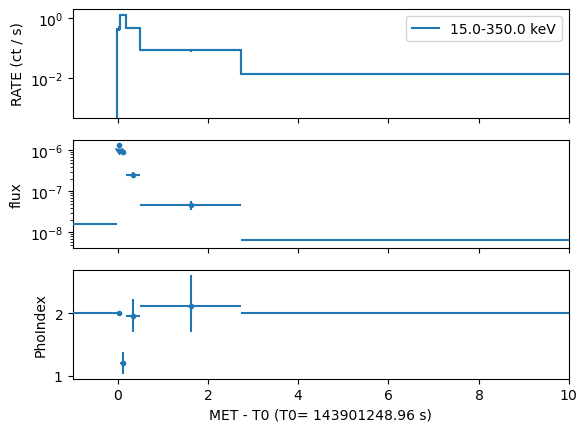

In [24]:
#ba.plot_TTE_lightcurve(lc, [spectrum_t90], plot_relative=True, T0=event.trigtime.met)
fig, ax = ba.plot_TTE_lightcurve(lc, output_bayesian_spectra, plot_relative=True, T0=event.trigtime.met)#, energy_range=None)
for i in ax:
    #i.set_xlim([-1,120])
    i.set_xlim([-1,10])
    
ax[0].set_yscale("log")

In [68]:
#calculate the estimated E_pk from Sakamoto+ 2009

def epk_estimator(spectra):
    all_data = ba.concatenate_spectrum_data(spectra, keys=["PhoIndex"])
    print(all_data)

    ep=np.ones(len(output_bayesian_spectra))
    ep_ll=np.ones_like(ep)
    ep_ul=np.ones_like(ep)


    ep=10**(3.258 - 0.829*all_data["PhoIndex"])
    ep_ll=10**(-20.684 + 43.646*all_data["PhoIndex"] - 26.891*all_data["PhoIndex"]**2 + 5.185*all_data["PhoIndex"]**3)
    ep_ul=10**(-5.198 + 16.568*all_data["PhoIndex"]-10.630*all_data["PhoIndex"]**2 + 2.034*all_data["PhoIndex"]**3)

    ep[np.isnan(all_data["PhoIndex_lolim"])]=np.nan

    print(ep)
    
    return ep,ep_ll, ep_ul

ep,ep_ll, ep_ul = epk_estimator(output_bayesian_spectra)

{'PhoIndex': array([2.        , 2.        , 1.2114428 , 1.95320514, 2.12176279,
       2.01112211, 2.        ]), 'TIME_START': <Quantity [1.43900950e+08, 1.43901249e+08, 1.43901249e+08, 1.43901249e+08,
           1.43901249e+08, 1.43901252e+08, 1.43901356e+08] s>, 'TIME_STOP': <Quantity [1.43901249e+08, 1.43901249e+08, 1.43901249e+08, 1.43901249e+08,
           1.43901252e+08, 1.43901356e+08, 1.43901552e+08] s>, 'PhoIndex_lolim': array([       nan,        nan, 0.17751626, 0.2565382 , 0.41798278,
       0.28046267,        nan]), 'PhoIndex_hilim': array([       nan,        nan, 0.17748675, 0.27376334, 0.4892528 ,
       0.29951775,        nan]), 'PhoIndex_upperlim': array([False, False, False, False, False, False, False])}
[         nan          nan 179.3551795   43.53042819  31.55430704
  38.97443006          nan]


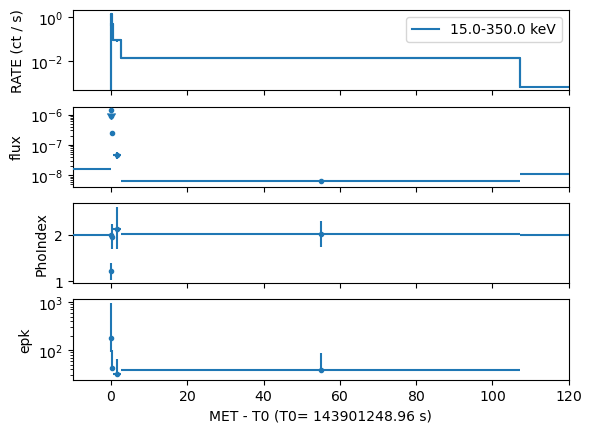

In [67]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

fig, ax = ba.plot_TTE_lightcurve(lc, output_bayesian_spectra, plot_relative=True, T0=event.trigtime.met, values=["flux", "phoindex", "epk"])#, energy_range=None)
for i in ax:
    i.set_xlim([-10,120])
    #i.set_xlim([-1,10])
    
ax[0].set_yscale("log")

tbin_cent=0.5*(all_data["TIME_START"].value+all_data["TIME_STOP"].value)-event.trigtime.met
tbin_err=0.5*(all_data["TIME_STOP"].value-all_data["TIME_START"].value)

ax[-1].errorbar(tbin_cent, ep, xerr=tbin_err, yerr=[ep_ll, ep_ul], linestyle="None", marker="o", markersize=3, color=colors[0])
ax[-1].set_yscale("log")




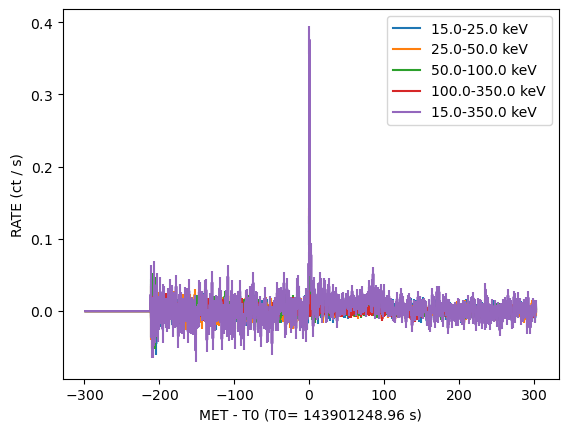

In [19]:
lc_1s=event.create_lightcurve(timebinalg="uniform", timedelta=np.timedelta64(1, "s"))#, tstart=-1*u.s, tstop=1*u.s, is_relative=True, T0=event.trigtime.met)
fig, ax =lc_1s.plot(T0=event.trigtime.met, plot_relative=True)

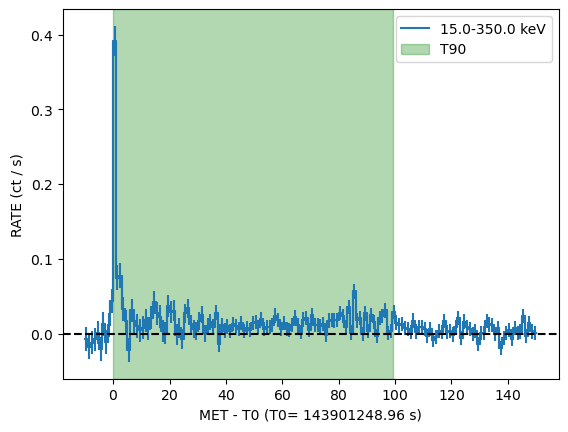

In [20]:
lc_1s.set_timebins(tmin=-10*u.s, tmax=150*u.s, timedelta=np.timedelta64(1, "s"), is_relative=True, T0=event.trigtime.met)
fig, ax =lc_1s.plot(energybins=[15,350]*u.keV, T0=event.trigtime.met, plot_relative=True)
ax.axhline(0, c='k', ls='--')

ax.axvspan((lc.tdurs['T90']['TSTART']-event.trigtime.met*u.s).value, (lc.tdurs['T90']['TSTOP']-event.trigtime.met*u.s).value, color='g', alpha=0.3, label="T90")
ax.legend()


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='E (keV)', ylabel='Count Rate (ct/s)'>)

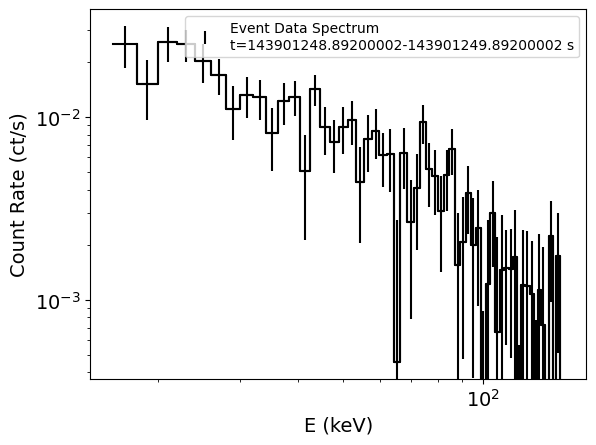

In [21]:
spectrum_peak_1s=event.create_pha(tstart=lc.tdurs['PEAK']['TSTART'], tstop=lc.tdurs['PEAK']['TSTOP'])
spectrum_peak_1s.plot()


1 spectrum  in use
 
Spectral Data File: t_143901248.89200002-143901249.89200002_80chan.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.259e-01 +/- 3.243e-02
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-80
  Telescope: SWIFT Instrument: BAT  Channel Type: PI
  Exposure Time: 1 sec
 Using fit statistic: cstat
 Using Response (RMF) File            t_143901248.89200002-143901249.89200002_80chan.rsp for Source 1


Fit statistic  : C-Statistic                    1.84     using 80 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                  404.96     using 80 bins.
 Null hypothesis probability of 2.75e-45 with 79 degrees of freedom
 Current data and model not fit yet.

Model cflux<1>*powerlaw<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   cflux      Emin       keV      0.500000     frozen
   2    1   cflux      Emax       keV      10.0000      frozen
   3    1   cflux

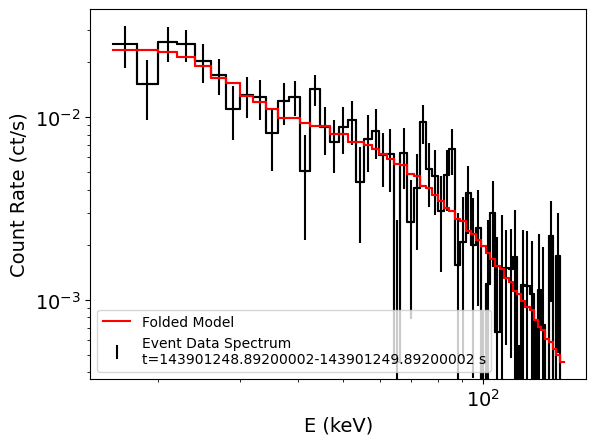

In [22]:
ba.fit_spectrum(spectrum_peak_1s, use_cstat=False)

In [23]:
peak_flux = event.create_lightcurve(tstart=lc.tdurs['PEAK']['TSTART'],tstop=lc.tdurs['PEAK']['TSTOP'], timedelta=np.timedelta64(0, "s"))
print(peak_flux.data["RATE"]*(lc.tdurs['PEAK']['TSTOP']-lc.tdurs['PEAK']['TSTART']))


[[0.1196039  0.13763913 0.10381171 0.02115031 0.38220506]] ct



1 spectrum  in use
 
Spectral Data File: t_143901248.944-143901356.144_80chan.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.067e-02 +/- 1.933e-03
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-80
  Telescope: SWIFT Instrument: BAT  Channel Type: PI
  Exposure Time: 107.2 sec
 Using fit statistic: chi
 Using Response (RMF) File            t_143901248.944-143901356.144_80chan.rsp for Source 1


Fit statistic  : Chi-Squared                146916.3     using 80 bins.

Test statistic : Chi-Squared                146916.3     using 80 bins.
 Null hypothesis probability of 0.0e+00 with 78 degrees of freedom
 Current data and model not fit yet.

Model cflux<1>*powerlaw<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   cflux      Emin       keV      0.500000     frozen
   2    1   cflux      Emax       keV      10.0000      frozen
   3    1   cflux      lg10Flux   cgs      -12.0000     +/-  0.0          
   4    2

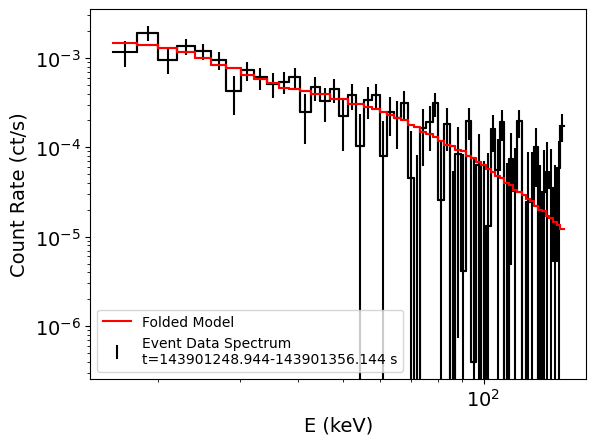

In [24]:
spectrum_peak_tot=event.create_pha(tstart=lc.tdurs['TOT']['TSTART'], tstop=lc.tdurs['TOT']['TSTOP'])
ba.fit_spectrum(spectrum_peak_tot, use_cstat=False)


In [25]:
total_fluence = event.create_lightcurve(tstart=lc.tdurs['TOT']['TSTART'], tstop=lc.tdurs['TOT']['TSTOP'], timedelta=np.timedelta64(0, "s"))
print(total_fluence.data["RATE"]*(lc.tdurs['TOT']['TSTOP']-lc.tdurs['TOT']['TSTART']))

[[0.76122338 0.71934947 0.35463966 0.14356256 1.97877507]] ct



1 spectrum  in use
 
Spectral Data File: t_143901248.944-143901356.144_80chan.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.067e-02 +/- 1.933e-03
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-80
  Telescope: SWIFT Instrument: BAT  Channel Type: PI
  Exposure Time: 107.2 sec
 Using fit statistic: cstat
 Using Response (RMF) File            t_143901248.944-143901356.144_80chan.rsp for Source 1


Fit statistic  : C-Statistic                    1.08     using 80 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                  123.16     using 80 bins.
 Null hypothesis probability of 1.09e-03 with 79 degrees of freedom
 Current data and model not fit yet.

Model cflux<1>*grbm<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   cflux      Emin       keV      0.500000     frozen
   2    1   cflux      Emax       keV      10.0000      frozen
   3    1   cflux      lg10Flux   cgs

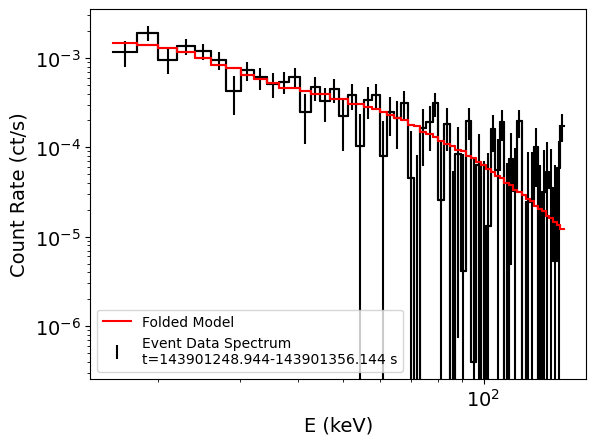

In [43]:
ba.fit_spectrum(spectrum_peak_tot, use_cstat=False, generic_model="cflux*grbm", setPars={1:"15,-1", 2:"150,-1",3:-8, 4:"-2",5:"-2",6:100, 7:"1e-3,-1"}, fit_iterations=10000)